In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install xformers trl peft accelerate bitsandbytes

In [ ]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 4.4 MB/s eta 0:00:00


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 512 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",          # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.27.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=32,  # Increased rank
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=32,  # Increased scaling factor
    lora_dropout=0,  # Optimized dropout
    bias="none",  # Optimized bias
    use_gradient_checkpointing="unsloth",  # Efficient gradient checkpointing
    random_state=3407,  # Consistent random state
    use_rslora=True,  # Enabled rank-stabilized LoRA
    loftq_config=None,  # No LoftQ configuration
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
from datasets import load_dataset

In [ ]:
eval = load_dataset('json', data_files="/content/drive/MyDrive/Llama3.1FineTuning/Diesease FAQS/all_faqs.json", split="train")
eval

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Question', 'Answer'],
    num_rows: 6607
})

In [ ]:
train = load_dataset('json', data_files="/content/drive/MyDrive/Llama3.1FineTuning/Diesease FAQS/aug_dataset_filtered.json", split="train")
train

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Question', 'Answer'],
    num_rows: 34642
})

In [ ]:
Q_A_template = """### Question: {}
### Answer: {}"""

EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs = examples["Question"]
    outputs = examples["Answer"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = Q_A_template.format(input, output) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

train = train.map(formatting_prompts_func, batched=True)
eval = eval.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/34642 [00:00<?, ? examples/s]

Map:   0%|          | 0/6607 [00:00<?, ? examples/s]

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, AutoModelForSequenceClassification
from unsloth import is_bfloat16_supported

# Load the checkpoint
model, tokenizer = FastLanguageModel.from_pretrained("/content/drive/MyDrive/Llama3.1FineTuning/Diesease FAQS/checkpoint-3000")

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.27.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train,  # Train dataset name
    eval_dataset=eval,  # Evaluation dataset name
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        learning_rate=5e-5,
        lr_scheduler_type="cosine",
        per_device_train_batch_size=16,
        gradient_accumulation_steps=1,
        num_train_epochs=2,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,  # Print loss every 10 steps
        optim="adamw_8bit",
        weight_decay=0.005,
        warmup_steps=10,
        output_dir="/content/drive/MyDrive/Llama3.1FineTuning/Diesease FAQS/",
        seed=3407,
        evaluation_strategy="steps",  # Evaluate every step
        eval_steps=500,  # Evaluate at each step
        save_strategy="steps",
        save_steps=500,
        save_total_limit=2,
        load_best_model_at_end=False,  # Don't load the best model, load the last checkpoint instead
        metric_for_best_model="loss",
        greater_is_better=False,
        save_on_each_node=True,  # Save checkpoints on each node
        resume_from_checkpoint=True,  # Resume from the last checkpoint
    ),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Continue training from the last checkpoint
trainer_stats = trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss
3500,0.506000,0.273559
4000,0.448300,0.262257


In [ ]:
model = FastLanguageModel.for_inference(model)

In [ ]:
input_text = "How to cure diabetes?"
input_ids = tokenizer.encode(input_text, return_tensors="pt")

output = model.generate(input_ids, max_length=512)

# Decode the output and remove the question
answer = tokenizer.decode(output[0], skip_special_tokens=True)
answer = answer.replace(input_text, '').strip()  # Remove the question and leading/trailing spaces

print("Question:", input_text)
print("Answer:", answer)

Question: How to cure diabetes?
Answer: The ultimate guide to reversing diabetes
How to reverse diabetes? Diabetes is a chronic condition that affects millions of people worldwide. Unfortunately, there is no cure for diabetes, but there are ways to reverse the effects of the disease and improve overall health.
One of the most important things people with diabetes can do is to follow their doctor’s recommended treatment plan, which typically includes taking medications, monitoring blood glucose levels, and making lifestyle changes.
In addition to the standard treatment, there are alternative therapies and dietary changes that some people find helpful in reversing the effects of diabetes úplně.
The goal of reversing diabetes is to reduce or eliminate the need for medications, improve insulin sensitivity,	cličková insulinová hodnota, and lower the risk of complications. It is important to note that reversing diabetes does not mean curing the condition, as it is a chronic disease.
With the

In [ ]:
model.save_pretrained("/content/drive/MyDrive/checkpoint-4332")

In [ ]:
# Create a new Trainer instance with the already loaded model
trainer2 = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    eval_dataset=eval,  # Evaluation dataset name
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        output_dir="/content/drive/MyDrive/Llama3.1FineTuning/Diesease FAQS/",
        per_device_eval_batch_size=16,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        save_total_limit=2,
        load_best_model_at_end=False,
        metric_for_best_model="loss",
        greater_is_better=False,
        save_on_each_node=True,
        resume_from_checkpoint=False,  # Set to False for evaluation
    ),
)

# Evaluate the model
trainer2.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map (num_proc=2):   0%|          | 0/6607 [00:00<?, ? examples/s]

{'eval_loss': 0.43247973918914795,
 'eval_model_preparation_time': 0.0192,
 'eval_runtime': 631.9257,
 'eval_samples_per_second': 10.455,
 'eval_steps_per_second': 0.654}

Plotting loss after each steps...

In [2]:
import matplotlib.pyplot as plt
import torch
import os

In [4]:
# Set the directory path where your checkpoint files are saved
checkpoint_dir = "/content/drive/MyDrive/Llama3.1FineTuning/Diesease FAQS"

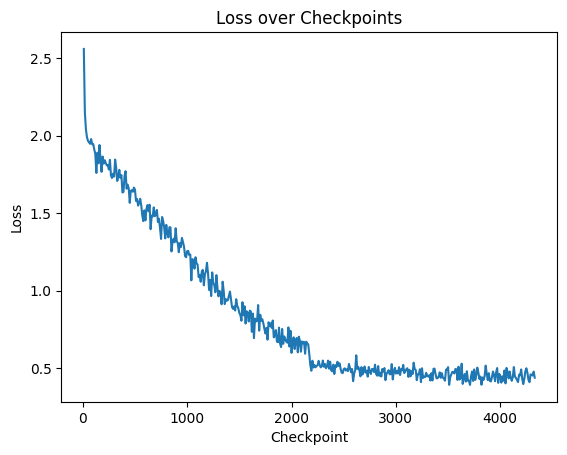

In [13]:
import os
import json
import matplotlib.pyplot as plt

# Initialize lists to store loss values and checkpoint numbers
loss_values = []
checkpoint_numbers = []

# Loop through each checkpoint directory in the directory
for dir in os.listdir(checkpoint_dir):
    if dir.startswith("checkpoint-"):
        # Load the trainer stats file
        trainer_stats_file = os.path.join(checkpoint_dir, dir, 'trainer_state.json')
        with open(trainer_stats_file, 'r') as f:
            trainer_stats = json.load(f)

        # Extract the log history from the trainer stats
        log_history = trainer_stats.get('log_history', [])

        # Extract the loss values and corresponding step numbers from the log history
        for log in log_history:
            loss = log.get('loss')
            step = log.get('step')

            # Append the loss value and step number to the lists
            if loss is not None and step is not None:
                loss_values.append(loss)
                checkpoint_numbers.append(step)

# Sort the loss values and checkpoint numbers based on the checkpoint number
loss_values = [x for _, x in sorted(zip(checkpoint_numbers, loss_values))]
checkpoint_numbers.sort()

# Create the plot
plt.plot(checkpoint_numbers, loss_values)
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.title("Loss over Checkpoints")
plt.show()

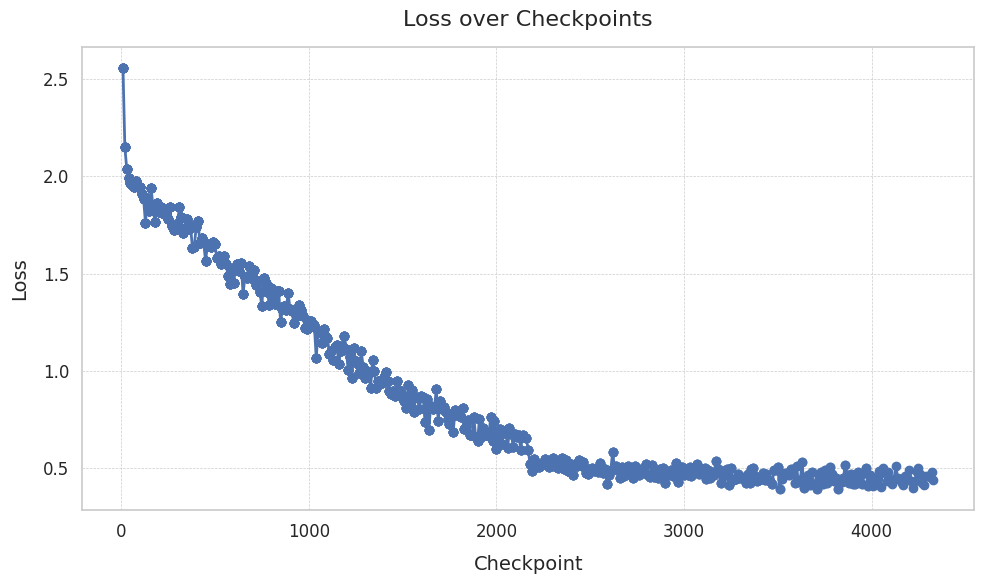

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a theme using Seaborn for better aesthetics
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(checkpoint_numbers, loss_values, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Add labels and title with customized font size
plt.xlabel("Checkpoint", fontsize=14, labelpad=10)
plt.ylabel("Loss", fontsize=14, labelpad=10)
plt.title("Loss over Checkpoints", fontsize=16, pad=15)

# Customize x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optionally, add some padding around the plot
plt.tight_layout()

# Display the plot
plt.show()